In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [0]:
from keras import models
from keras import layers
from keras import metrics
from keras import optimizers

import numpy as np
import json
import os
import csv
import pandas as pd
import tensorflow_addons as tfa

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read json 2-d pose as data, without using: 
#     {15, "REye"},
#     {16, "LEye"},
#     {17, "REar"},
#     {18, "LEar"}

ur_basepath1 = '/content/drive/My Drive/636project/data/fall_UR/fall-cam0'
ur_basepath2 = '/content/drive/My Drive/636project/data/adl_UR'
mc_fall_path = '/content/drive/My Drive/636project/data/MCdataset/mc_fall'
mc_notfall_path = '/content/drive/My Drive/636project/data/MCdataset/mc-notfall'

def input_data(basepath):
  data = []
  entries = os.listdir(basepath)
  for entry in entries:
    path = os.path.join(basepath, entry)
    frames = os.listdir(path)
    for frame in frames:
      frame_path = os.path.join(path, frame)
      with open(frame_path, mode='r') as json_file:
        people_dict = json.load(json_file)
        people = people_dict["people"]
        pose_keypoints_2d = []
        # fill missing data as 0
        if len(people) == 0:
          pose_keypoints_2d = [0] * 63
        else:
          full_pose = people[0].get("pose_keypoints_2d")
          pose_keypoints_2d = full_pose[:45] + full_pose[57:]
         
        pose_keypoints_2d.append(frame.split('.')[0])
        # each pose_keypoints_2d: 
        #    [431.949, 196.241, 0.0564434, 437.194, 187.749, 0.552267,...'fall-06-cam0_000000000065_keypoints']
        # OR [123.949, 283.241, 0.0564434, 437.194, 187.749, 0.552267,...'43_000000000000_keypoints']
        data.append(pose_keypoints_2d)        
  return data

# read the data of UR dataset  
# http://fenix.univ.rzeszow.pl/~mkepski/ds/uf.html
ur_data1 = input_data(ur_basepath1)
print(len(ur_data1))

ur_data2 = input_data(ur_basepath2)
print(len(ur_data2))
 
ur_data = ur_data1 + ur_data2
print("length of UR dataset: ", len(ur_data))

df1 = pd.DataFrame.from_records(ur_data)
df1.to_csv (r'/content/drive/My Drive/636project/ur_data.csv', index = False, header=False)

# read the data of MC dataset
# http://www.iro.umontreal.ca/~labimage/Dataset/
mc_fall_data = input_data(mc_fall_path)
print(len("length of mc-fall dataset: ", mc_fall_data))


df2 = pd.DataFrame.from_records(mc_fall_data)
df2.to_csv(r'/content/drive/My Drive/636project/mc_fall_data.csv', index = False, header=False)

mc_notfall_data = input_data(mc_notfall_path)
print(len("length of mc-not-fall dataset: ", mc_notfall_data))

df3 = pd.DataFrame.from_records(mc_notfall_data)
df3.to_csv(r'/content/drive/My Drive/636project/mc_notfall_data.csv', index = False, header=False)

2995
8941
length of UR dataset 11936
9488
8236


In [4]:
# read the video data csv,
# it is faster than running the above code each time

ur_path = '/content/drive/My Drive/636project/ur_data.csv'
mc_fall_path = '/content/drive/My Drive/636project/mc_fall_data.csv'
mc_notfall_path = '/content/drive/My Drive/636project/mc_notfall_data.csv'

def read_data(path):
  video_data = []
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      video_data.append(row)
  return video_data

ur_data = read_data(ur_path)
mc_fall_data = read_data(mc_fall_path)
mc_notfall_data = read_data(mc_notfall_path)

print(ur_data[0])
print(mc_fall_data[0])
print(mc_notfall_data[0])

['520.972', '128.178', '0.833728', '544.571', '130.782', '0.739747', '540.636', '132.754', '0.726633', '553.086', '154.999', '0.800764', '541.285', '166.155', '0.742877', '549.144', '129.467', '0.745059', '572.703', '155.035', '0.841464', '543.266', '171.369', '0.817947', '572.067', '169.415', '0.607432', '564.874', '166.16', '0.534525', '526.875', '181.191', '0.862423', '554.389', '217.851', '0.612664', '577.962', '170.732', '0.619415', '535.402', '188.398', '0.760066', '560.284', '220.479', '0.65847', '545.882', '232.266', '0.604373', '553.078', '232.915', '0.532739', '566.184', '222.453', '0.655722', '541.939', '229.002', '0.399536', '541.943', '227.687', '0.344383', '560.285', '217.223', '0.153482', 'fall-16-cam0_000000000016_keypoints']
['504.171', '238.019', '0.119379', '481.995', '237.979', '0.647555', '471.564', '247.106', '0.6547', '485.918', '299.334', '0.780827', '525.04', '307.158', '0.770417', '495.036', '228.845', '0.474206', '519.863', '220.995', '0.283234', '539.41', '2

In [5]:
# read target label of UR dataset. 

target = []
path1 = '/content/drive/My Drive/636project/target/urfall-cam0-falls.csv'
path2 = '/content/drive/My Drive/636project/target/urfall-cam0-adls.csv'
# in these csv of UR dataset, 
# '-1' means person is not lying, '1' means person is lying on the ground; '0' is temporary pose, when person "is falling"

def input_fall(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      label = row[2]
      if label == '1' or label == '0':
        record.append(1)        
      else:
        record.append(0)
      # each record: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0] 
      target.append(record)

# though laying in the video, but it is not fall, so I mark 0 as label
def input_adl(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      record.append(0)
      target.append(record)

input_fall(path1)
print("falls of UR dataset", len(target))

input_adl(path2)

df = pd.DataFrame.from_records(target)
df.to_csv (r'/content/drive/My Drive/636project/target_data.csv', index = False, header=False)


falls of UR dataset 2995


In [0]:
# make dictionary of target of ur dataset
target_csv_path = '/content/drive/My Drive/636project/target_data.csv'
idx = 0
idx_dict = {}

with open(target_csv_path, mode='r') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    # each row: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0] 
    idx_dict['.'.join(row[:2])] = idx  # {'fall-17.22' : 112}
    idx += 1

In [7]:
# match body landmark data with label data of ur dataset
bodylandmark = []
label = []
frame_name = []

for landmark in ur_data:
  video_name = landmark[-1].split('_')  # 'fall-01-cam0_000000000004'
  a = video_name[0].split('-')
  video_type = a[0] # 'fall'
  video_id = a[1]   # '01'
  frame_id = str(int(video_name[1])) # '000000000004' become '4'
  try:
    a = '.'.join([video_id, frame_id])
    b = '-'.join([video_type, a])
    label.append(target[idx_dict[b]][-1])
    bl = landmark[:-1]
    # convert string into float
    bl = list(map(float,bl))
    bodylandmark.append(bl)
    frameName = landmark[-1]
    frame_name.append(frameName)
  except:
    continue

print("bodylandmark record sample of ur dataset:" )
print(bodylandmark[0])
print("label of ur dataset: ", len(label))
print("bodylandmark of ur dataset: ", len(bodylandmark))
print(frame_name[0])

bodylandmark record sample of ur dataset:
[520.972, 128.178, 0.833728, 544.571, 130.782, 0.739747, 540.636, 132.754, 0.726633, 553.086, 154.999, 0.800764, 541.285, 166.155, 0.742877, 549.144, 129.467, 0.745059, 572.703, 155.035, 0.841464, 543.266, 171.369, 0.817947, 572.067, 169.415, 0.607432, 564.874, 166.16, 0.534525, 526.875, 181.191, 0.862423, 554.389, 217.851, 0.612664, 577.962, 170.732, 0.619415, 535.402, 188.398, 0.760066, 560.284, 220.479, 0.65847, 545.882, 232.266, 0.604373, 553.078, 232.915, 0.532739, 566.184, 222.453, 0.655722, 541.939, 229.002, 0.399536, 541.943, 227.687, 0.344383, 560.285, 217.223, 0.153482]
label of ur dataset:  11475
bodylandmark of ur dataset:  11475
fall-16-cam0_000000000016_keypoints


In [0]:
# add data of MC dataset to the whole dataset
# For MC dataset, all frames in fall data should be label 1, 
# and all frames in notfall data should be label 0.
for record in mc_fall_data:
  bl = record[:-1]
  bl = list(map(float,bl))
  bodylandmark.append(bl)
  label.append(1)
  frameName = record[-1]
  frame_name.append(frameName)

for record in mc_notfall_data:
  bl = record[:-1]
  bl = list(map(float,bl))
  bodylandmark.append(bl)
  label.append(0)
  frameName = record[-1]
  frame_name.append(frameName)


In [9]:
# normalize data 
for record in bodylandmark:
  for i in range(0, 63, 3):
    record[i] = float(record[i])/ 640
    record[i + 1] = float(record[i + 1]) / 480

print(bodylandmark[0])
print(len(label))
print(len(bodylandmark))

[0.81401875, 0.2670375, 0.833728, 0.8508921875000001, 0.2724625, 0.739747, 0.8447437499999999, 0.2765708333333333, 0.726633, 0.864196875, 0.32291458333333334, 0.800764, 0.8457578124999999, 0.34615625, 0.742877, 0.8580375, 0.2697229166666667, 0.745059, 0.8948484375, 0.32298958333333333, 0.841464, 0.848853125, 0.35701875, 0.817947, 0.8938546875, 0.35294791666666664, 0.607432, 0.882615625, 0.3461666666666667, 0.534525, 0.8232421875, 0.37748125, 0.862423, 0.8662328125000001, 0.45385625, 0.612664, 0.903065625, 0.3556916666666667, 0.619415, 0.8365656250000001, 0.3924958333333333, 0.760066, 0.87544375, 0.45933125, 0.65847, 0.8529406249999999, 0.48388749999999997, 0.604373, 0.864184375, 0.48523958333333334, 0.532739, 0.8846624999999999, 0.46344375, 0.655722, 0.8467796875, 0.4770875, 0.399536, 0.8467859375, 0.4743479166666667, 0.344383, 0.8754453124999999, 0.4525479166666667, 0.153482]
29199
29199


In [10]:
# make bodylandmark and label to be a same data frame
all_data = []

for i in range(len(bodylandmark)):
  all_data.append([label[i]])
  all_data[i] = all_data[i] + bodylandmark[i]

print(all_data[0])
print(len(all_data))
print(len(all_data[0]))

[0, 0.81401875, 0.2670375, 0.833728, 0.8508921875000001, 0.2724625, 0.739747, 0.8447437499999999, 0.2765708333333333, 0.726633, 0.864196875, 0.32291458333333334, 0.800764, 0.8457578124999999, 0.34615625, 0.742877, 0.8580375, 0.2697229166666667, 0.745059, 0.8948484375, 0.32298958333333333, 0.841464, 0.848853125, 0.35701875, 0.817947, 0.8938546875, 0.35294791666666664, 0.607432, 0.882615625, 0.3461666666666667, 0.534525, 0.8232421875, 0.37748125, 0.862423, 0.8662328125000001, 0.45385625, 0.612664, 0.903065625, 0.3556916666666667, 0.619415, 0.8365656250000001, 0.3924958333333333, 0.760066, 0.87544375, 0.45933125, 0.65847, 0.8529406249999999, 0.48388749999999997, 0.604373, 0.864184375, 0.48523958333333334, 0.532739, 0.8846624999999999, 0.46344375, 0.655722, 0.8467796875, 0.4770875, 0.399536, 0.8467859375, 0.4743479166666667, 0.344383, 0.8754453124999999, 0.4525479166666667, 0.153482]
29199
64


In [11]:
print(len(frame_name))

29199


In [12]:
# prepare data to detect and analyse fail cases of the final models
sample_data_for_fail = []
for i in range(len(all_data)):
  toAdd = []
  for record in all_data[i]:
    toAdd.append(record)
  toAdd.append(frame_name[i])
  sample_data_for_fail.append(toAdd)

print(sample_data_for_fail[0])

[0, 0.81401875, 0.2670375, 0.833728, 0.8508921875000001, 0.2724625, 0.739747, 0.8447437499999999, 0.2765708333333333, 0.726633, 0.864196875, 0.32291458333333334, 0.800764, 0.8457578124999999, 0.34615625, 0.742877, 0.8580375, 0.2697229166666667, 0.745059, 0.8948484375, 0.32298958333333333, 0.841464, 0.848853125, 0.35701875, 0.817947, 0.8938546875, 0.35294791666666664, 0.607432, 0.882615625, 0.3461666666666667, 0.534525, 0.8232421875, 0.37748125, 0.862423, 0.8662328125000001, 0.45385625, 0.612664, 0.903065625, 0.3556916666666667, 0.619415, 0.8365656250000001, 0.3924958333333333, 0.760066, 0.87544375, 0.45933125, 0.65847, 0.8529406249999999, 0.48388749999999997, 0.604373, 0.864184375, 0.48523958333333334, 0.532739, 0.8846624999999999, 0.46344375, 0.655722, 0.8467796875, 0.4770875, 0.399536, 0.8467859375, 0.4743479166666667, 0.344383, 0.8754453124999999, 0.4525479166666667, 0.153482, 'fall-16-cam0_000000000016_keypoints']


In [13]:
# know the majority and minority
fall = label.count(1)
not_fall = label.count(0)
print(fall)
print(not_fall)

11261
17938


In [14]:
# up-sampling to make the data balance
# Separate majority and minority classes
df = pd.DataFrame.from_records(all_data)
header = ['label']
for i in range(63):
  header.append(i)

df.columns = header
df_majority = df[df.label==0]
df_minority = df[df.label==1]
print("before re-sampling, not fall vs fall: ")
print(df['label'].value_counts())

from sklearn.utils import resample
print("begin to re sample...")
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=17938)    # to match majority class
                                  
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print("after re-sampling...")
# Display new class counts
df_upsampled.label.value_counts()

before re-sampling, not fall vs fall: 
0    17938
1    11261
Name: label, dtype: int64
begin to re sample...
after re-sampling...


1    17938
0    17938
Name: label, dtype: int64

In [15]:
all_data = df_upsampled.values

print(all_data[0])
print(len(all_data[0]))
print("number of all data:", len(all_data))

[0.         0.81401875 0.2670375  0.833728   0.85089219 0.2724625
 0.739747   0.84474375 0.27657083 0.726633   0.86419687 0.32291458
 0.800764   0.84575781 0.34615625 0.742877   0.8580375  0.26972292
 0.745059   0.89484844 0.32298958 0.841464   0.84885312 0.35701875
 0.817947   0.89385469 0.35294792 0.607432   0.88261563 0.34616667
 0.534525   0.82324219 0.37748125 0.862423   0.86623281 0.45385625
 0.612664   0.90306562 0.35569167 0.619415   0.83656563 0.39249583
 0.760066   0.87544375 0.45933125 0.65847    0.85294062 0.4838875
 0.604373   0.86418438 0.48523958 0.532739   0.8846625  0.46344375
 0.655722   0.84677969 0.4770875  0.399536   0.84678594 0.47434792
 0.344383   0.87544531 0.45254792 0.153482  ]
64
number of all data: 35876


In [16]:
# split data into train and test set
np.random.shuffle(all_data)
split_point = len(all_data) // 9
print("split point:", split_point)
test_data = all_data[:split_point]
train_data = all_data[split_point: ]

print("number of test data:", len(test_data))
print("number of train data:",len(train_data))

print(train_data[0])

split point: 3986
number of test data: 3986
number of train data: 31890
[1.         0.69407344 0.53113542 0.749696   0.65530312 0.56105208
 0.710325   0.65528594 0.53395208 0.45351    0.60225469 0.50928542
 0.538867   0.56352031 0.46865417 0.648747   0.65731406 0.5937
 0.62183    0.61039687 0.62364583 0.776324   0.56150625 0.66433125
 0.829948   0.54513281 0.55017083 0.646124   0.54514688 0.53118542
 0.619853   0.45746563 0.51222083 0.561223   0.37796719 0.55282083
 0.5152     0.54310469 0.56652083 0.53076    0.45345    0.56379583
 0.530622   0.37596719 0.58011875 0.420266   0.34739063 0.54204375
 0.303624   0.34534531 0.5556625  0.264057   0.36366719 0.5855375
 0.391625   0.34940469 0.52843125 0.445797   0.35145156 0.52574583
 0.451493   0.36565    0.56103125 0.390428  ]


In [0]:
# plotting the results

import matplotlib.pyplot as plt

def plotting_training(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  # Plot training & validation loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label="Training loss")
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epoch', fontsize=10)
  plt.ylabel('loss', fontsize=10)
  plt.ylim(0.0,0.5)
  plt.legend()
  plt.show()

In [23]:
# solution 1: train model using lstm
from tensorflow.keras.layers import LSTM
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from numpy import array
from tensorflow.keras.models import Sequential

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

x_train = []
y_train = []

for record in train_data:
  x_train.append(record[1:])
  label = int(record[0])
  y_train.append(label) 

def train_lstm_model(x_train, y_train):
  x_train = array(x_train)
  x_train = x_train.reshape((len(x_train), 1, len(x_train[0])))
  print("x_train.shape", x_train.shape)
  print(x_train[0])

  y_train = array(y_train)
  print("y_train.shape", y_train.shape)

  # imrpove log: use batch size 16 and add one more lstm layer

  lstm_model = Sequential()
  lstm_model.add(LSTM(16, 
                input_shape=(1, 63),
                return_sequences=True))
  lstm_model.add(LSTM(16, ))
  lstm_model.add(layers.Dense(1, activation='sigmoid'))
  lstm_model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc',
                        metrics.AUC(), 
                        metrics.FalseNegatives(),
                        metrics.Recall(),
                        metrics.Precision(),
                        metrics.FalseNegatives(),
                        metrics.TrueNegatives(),
                        metrics.FalsePositives(),
                        metrics.TruePositives()])
  lstm_history = lstm_model.fit(x_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split=0.2,
                      callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5),
                      callbacks.LearningRateScheduler(scheduler)])
  print("finish training lstm model")
  return lstm_model, lstm_history

lstm_model, lstm_history = train_lstm_model(x_train, y_train)

x_train.shape (31890, 1, 63)
[[0.69407344 0.53113542 0.749696   0.65530312 0.56105208 0.710325
  0.65528594 0.53395208 0.45351    0.60225469 0.50928542 0.538867
  0.56352031 0.46865417 0.648747   0.65731406 0.5937     0.62183
  0.61039687 0.62364583 0.776324   0.56150625 0.66433125 0.829948
  0.54513281 0.55017083 0.646124   0.54514688 0.53118542 0.619853
  0.45746563 0.51222083 0.561223   0.37796719 0.55282083 0.5152
  0.54310469 0.56652083 0.53076    0.45345    0.56379583 0.530622
  0.37596719 0.58011875 0.420266   0.34739063 0.54204375 0.303624
  0.34534531 0.5556625  0.264057   0.36366719 0.5855375  0.391625
  0.34940469 0.52843125 0.445797   0.35145156 0.52574583 0.451493
  0.36565    0.56103125 0.390428  ]]
y_train.shape (31890,)
Epoch 1/100
1595/1595 [==============================] - 14s 9ms/step - loss: 0.4169 - acc: 0.8105 - auc_3: 0.8322 - false_negatives_5: 1360.3173 - recall_3: 0.7113 - precision_3: 0.7575 - false_negatives_6: 1360.3173 - true_negatives_3: 5030.1714 - fals

In [24]:
lstm_model.summary()
lstm_model.save("/content/drive/My Drive/636project/model_improved_lstm.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 16)             5120      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


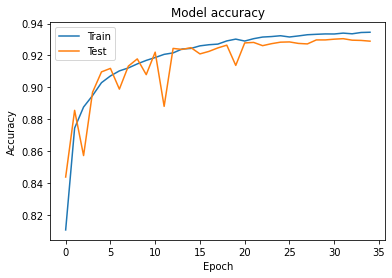

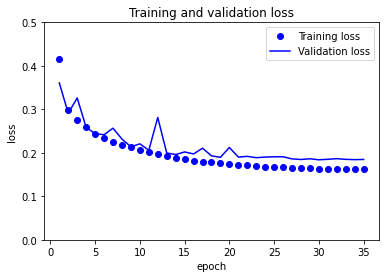

In [25]:
plotting_training(lstm_history)

In [30]:
# test 
# for lstm
x_test = []
y_test = []

for record in train_data:
  x_test.append(record[1:])
  label = int(record[0])
  y_test.append(label) 

x_test = array(x_test)
x_test = x_test.reshape((len(x_test), 1, len(x_test[0])))

y_test = array(y_test)

test_score = lstm_model.evaluate(x_test, y_test)
print(test_score)

997/997 [==============================] - 5s 5ms/step - loss: 0.1672 - acc: 0.9326 - auc_3: 0.9742 - false_negatives_5: 34228.1445 - recall_3: 0.9397 - precision_3: 0.9022 - false_negatives_6: 34228.1445 - true_negatives_3: 507151.3750 - false_positives_3: 57775.7812 - true_positives_3: 532962.4375
[0.16719713807106018, 0.9325807690620422, 0.9741894006729126, 34228.14453125, 0.9396514892578125, 0.9021955132484436, 34228.14453125, 507151.375, 57775.78125, 532962.4375]


In [27]:
# solution 2: train model using CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

x_train = []
y_train = []

for record in train_data:
  x_train.append(record[1:])
  label = int(record[0])
  y_train.append(label) 

def tain_cnn_model(x_train, y_train):
  x_train = array(x_train)
  x_train = x_train.reshape((len(x_train), 3, int(len(x_train[0])/3), 1))

  y_train = array(y_train)

  #create model
  cnn_model = Sequential()
  cnn_model.add(Conv2D(64, 
                  kernel_size=3, 
                  activation='relu', 
                  input_shape=(3,21,1), 
                  padding='same'))
  cnn_model.add(layers.BatchNormalization(1))
  cnn_model.add(Conv2D(64, 
                  kernel_size=3, 
                  activation='relu', 
                  padding='same'))
  cnn_model.add(layers.BatchNormalization(1))
  cnn_model.add(MaxPooling2D(2,2))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(512, activation = 'relu')) 
  cnn_model.add(Dense(1, activation='sigmoid'))

  # compile and fit
  cnn_model.compile(optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['acc', 
                        metrics.AUC(), 
                        metrics.FalseNegatives(),
                        metrics.Recall(),
                        metrics.Precision(),
                        metrics.FalseNegatives(),
                        metrics.TrueNegatives(),
                        metrics.FalsePositives(),
                        metrics.TruePositives()])
  cnn_history = cnn_model.fit(x_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split=0.2,
                      callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5),
                      callbacks.LearningRateScheduler(scheduler)])
    
  print("finish training cnn model")
  return cnn_model, cnn_history


cnn_model, cnn_history = tain_cnn_model(x_train, y_train)

Epoch 1/100
1595/1595 [==============================] - 11s 7ms/step - loss: 0.2648 - acc: 0.8899 - auc_5: 0.9219 - false_negatives_9: 694.5599 - recall_5: 0.8722 - precision_5: 0.8430 - false_negatives_10: 694.5599 - true_negatives_5: 5476.1650 - false_positives_5: 905.9066 - true_positives_5: 5691.3638 - val_loss: 0.2339 - val_acc: 0.9144 - val_auc_5: 0.9588 - val_false_negatives_9: 1383.1904 - val_recall_5: 0.9036 - val_precision_5: 0.8850 - val_false_negatives_10: 1383.1904 - val_true_negatives_5: 12683.2178 - val_false_positives_5: 1681.7770 - val_true_positives_5: 12963.7998 - lr: 0.0010
Epoch 2/100
1595/1595 [==============================] - 11s 7ms/step - loss: 0.1778 - acc: 0.9264 - auc_5: 0.9653 - false_negatives_9: 1982.2225 - recall_5: 0.9105 - precision_5: 0.8964 - false_negatives_10: 1982.2225 - true_negatives_5: 19983.9531 - false_positives_5: 2339.1580 - true_positives_5: 20352.6602 - val_loss: 0.1736 - val_acc: 0.9320 - val_auc_5: 0.9703 - val_false_negatives_9: 2481

In [28]:
cnn_model.summary()
cnn_model.save("/content/drive/My Drive/636project/model_improved_cnn.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 3, 21, 64)         640       
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 21, 64)         12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 21, 64)         36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 21, 64)         12        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 10, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

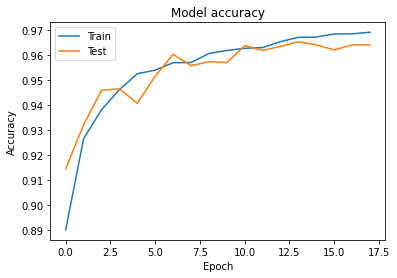

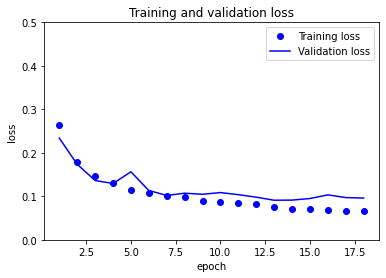

In [29]:
plotting_training(cnn_history)

In [31]:
# test
# for cnn 2d
x_test = []
y_test = []

for record in train_data:
  x_test.append(record[1:])
  label = int(record[0])
  y_test.append(label) 

x_test = array(x_test)
x_test = x_test.reshape((len(x_test), 3, int(len(x_test[0])/3), 1))

y_test = array(y_test)

test_score = cnn_model.evaluate(x_test, y_test)
print(test_score)

997/997 [==============================] - 5s 5ms/step - loss: 0.0713 - acc: 0.9679 - auc_5: 0.9918 - false_negatives_9: 7266.2437 - recall_5: 0.9754 - precision_5: 0.9362 - false_negatives_10: 7266.2437 - true_negatives_5: 274784.0312 - false_positives_5: 19639.0781 - true_positives_5: 288298.6250
[0.07127624750137329, 0.9679209589958191, 0.9918053150177002, 7266.24365234375, 0.9754136800765991, 0.9362214207649231, 7266.24365234375, 274784.03125, 19639.078125, 288298.625]


In [35]:
# get wrong predictions(fail cases) of cnn model
from numpy import array
import tensorflow as tf

sample_data_for_fail

cnn_model = tf.keras.models.load_model('/content/drive/My Drive/636project/model_improved_cnn.h5')

x_sample = []
y_sample = []

for record in sample_data_for_fail:
  x_sample.append(record[1:-1])
  label = int(record[0])
  y_sample.append(label) 

x_sample = array(x_sample)
x_sample = x_sample.reshape((len(x_sample), 3, int(len(x_sample[0])/3), 1))

y_sample = array(y_sample)

probality = cnn_model.predict(x_sample)

fails = []
false_negatives = []
false_positives = []

for i in range(len(probality)):
  if probality[i] >= 0.5:
    x = 1
  else:
    x = 0
  if x != y_sample[i]:
    fails.append(i)
    if x == 1:
      false_positive.append(i)
    else:
      false_negative.append(i)

print("number of fail cases of CNN model:", len(fails))

number of fail cases of CNN model: 1137


In [36]:
# get name of fail frames
fail_frames = []
for fail in fails:
  fail_frames.append(sample_data_for_fail[fail][-1])

print(fail_frames[0])

fall-16-cam0_000000000017_keypoints


In [0]:
df_fail_frames = pd.DataFrame.from_records(fail_frames)
df_fail_frames.to_csv (r'/content/drive/My Drive/636project/fail_frames.csv', index = False, header=False)

df_false_negative = pd.DataFrame.from_records(false_negatives)
df_false_negative.to_csv (r'/content/drive/My Drive/636project/false_negative_frames.csv', index = False, header=False)

df_false_positive = pd.DataFrame.from_records(false_positives)
df_false_positive.to_csv (r'/content/drive/My Drive/636project/false_positive_frames.csv', index = False, header=False)


In [0]:
# train the final lstm model with all data (include test data) 

x_train_final = []
y_train_final = []

for record in all_data:
  x_train_final.append(record[1:])
  label = int(record[0])
  y_train_final.append(label) 

final_lstm_model, final_lstm_history = train_lstm_model(x_train_final, y_train_final)

final_lstm_model.save("/content/drive/My Drive/636project/final_lstm_model.h5")

In [0]:
# train the final cnn model with all data (include test data) 
x_train_final = []
y_train_final = []

for record in all_data:
  x_train_final.append(record[1:])
  label = int(record[0])
  y_train_final.append(label) 

final_cnn_model, final_cnn_history = train_cnn_model(x_train_final, y_train)

final_model.save("/content/drive/My Drive/636project/final_cnn_model.h5")
